In [1]:
import json
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np

json_file = "../../experiments/exp004_20241022_sna_kadirburakerdem/data-tshark/data.json"
with open(json_file) as f:
    data = json.load(f)

# filter data by unique source addresses and get lists

In [2]:
lo_uniqueSAs = []
lo_freqs     = []
lo_SActrs    = []
lo_SSIDs     = []
for pkt in data:
    if(pkt["_source"]["layers"]["wlan.sa"] not in lo_uniqueSAs):
        lo_uniqueSAs.append(pkt["_source"]["layers"]["wlan.sa"])
        lo_freqs.append(pkt["_source"]["layers"]["wlan_radio.frequency"][0])
        lo_SActrs.append(1)
        lo_SSIDs.append(pkt["_source"]["layers"]["wlan.ssid"][0])
    else:
        position_of_uniqueSA_in_listofuniqueSAs = lo_uniqueSAs.index(pkt["_source"]["layers"]["wlan.sa"])
        lo_SActrs[position_of_uniqueSA_in_listofuniqueSAs] += 1

### per-SSID statistics

In [3]:
print("SSID | Source Address    |  Freq |  # of occurrences")
print("-"*50)
selected_AP_idx = []
for i, ssid in enumerate(lo_SSIDs):
    if ( ((ssid == "KU") and (lo_SActrs[i] > 1300)) or ("ekb_test" in ssid)):
        print(ssid, "  |", lo_uniqueSAs[i][0], "| ", lo_freqs[i], "| ", lo_SActrs[i])
        selected_AP_idx.append(i)

SSID | Source Address    |  Freq |  # of occurrences
--------------------------------------------------
KU   | 4c:77:6d:05:a4:00 |  2412 |  6351
KU   | 4c:77:6d:05:ab:e0 |  2412 |  5440
ekb_test_vr600   | d8:47:32:eb:6c:38 |  2412 |  6806
ekb_test_vr400   | 50:c7:bf:19:e6:4d |  2412 |  7023
KU   | 4c:77:6d:5f:dc:20 |  2412 |  6344
KU   | 4c:77:6d:a0:45:c0 |  2412 |  6635
KU   | 4c:77:6d:9d:e7:e0 |  2412 |  1438
ekb_test_air5443   | 18:28:61:3d:94:7a |  2412 |  2693


# plotting SSID occurrences

prototype

In [4]:
data[4]

{'_index': 'packets-2024-10-22',
 '_type': 'doc',
 '_score': None,
 '_source': {'layers': {'frame.time': ['18:18:41.660'],
   'wlan_radio.signal_dbm': ['-87'],
   'wlan.sa': ['4c:77:6d:05:ab:e1'],
   'wlan.ra': ['ff:ff:ff:ff:ff:ff'],
   'wlan.da': ['ff:ff:ff:ff:ff:ff'],
   'wlan_radio.frequency': ['2412'],
   'wlan.ssid': ['GUEST'],
   'loc_x': '1.7463105',
   'loc_y': '1.2628807'}}}

In [5]:
def frametime2secs(frametime):
    hrs   = int(frametime.split(":")[0])
    mins  = int(frametime.split(":")[1])
    secs  = int((frametime.split(":")[2]).split(".")[0])
    msecs = int((frametime.split(":")[2]).split(".")[1])
    total_seconds = (hrs*60*60*1000 + mins*60*1000 + secs*1000 + msecs) / 1000.0 
    return total_seconds

def get_timeinsecs(sampledict, offset=0):
    return frametime2secs(sampledict["_source"]["layers"]["frame.time"][0]) - offset;

def get_freq(sampledict):
    return sampledict["_source"]["layers"]["wlan_radio.frequency"][0]

def get_sourceaddr(sampledict):
    return sampledict["_source"]["layers"]["wlan.sa"]
    
def get_ssid(sampledict):
    return sampledict["_source"]["layers"]["wlan.ssid"][0]
    
def get_rss(sampledict):
    return sampledict["_source"]["layers"]["wlan_radio.signal_dbm"][0]

test fcns

In [6]:
print(get_timeinsecs(data[4], offset=64999.800))
print(get_freq(data[4]))
print(get_sourceaddr(data[4])[0])
print(get_ssid(data[4]))
print(get_rss(data[4]))

921.8600000000006
2412
4c:77:6d:05:ab:e1
GUEST
-87


get the time axis

In [7]:
time = []
for sample in data:
    t = get_timeinsecs(sample, offset=64999.800)
    if(t not in time):
        time.append(t)

### record KU RSS values

In [8]:
lo_uniqueSAs[selected_AP_idx[-1]]

['18:28:61:3d:94:7a']

In [9]:
array_ssid_rss = np.zeros((len(time), len(selected_AP_idx)))*np.nan
for sample in data:
    t_sample  = get_timeinsecs(sample, offset=64999.800)
    t_idx     = time.index(t_sample)
    sa_sample = get_sourceaddr(sample)
    sa_idx    = lo_uniqueSAs.index(sa_sample)
    if(sa_idx in selected_AP_idx):
        array_ssid_idx = selected_AP_idx.index(sa_idx)
        array_ssid_rss[t_idx, array_ssid_idx] = get_rss(sample)

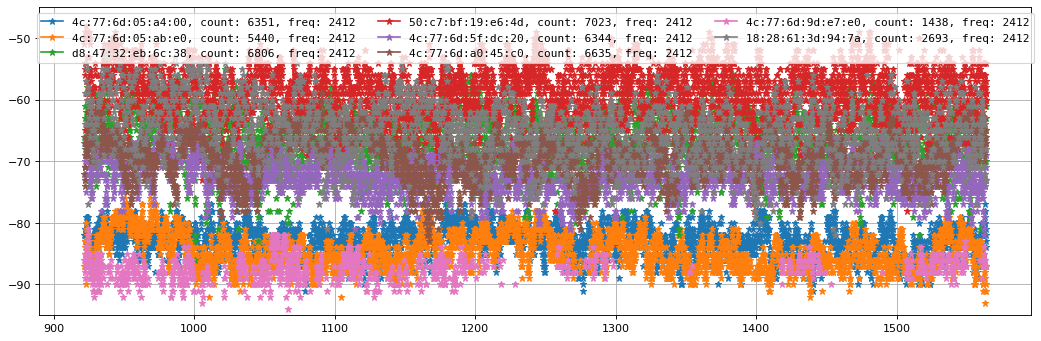

In [10]:
plt.figure(figsize=(16, 5), dpi=80)
plt.plot(time, array_ssid_rss, marker="*");
plt.ylim([-95, -45])
plt.grid()
plt.legend([(lo_uniqueSAs[idx][0]+ ", count: " + str(lo_SActrs[idx]) + ", freq: " + str(lo_freqs[idx])) for idx in selected_AP_idx], 
           prop=font_manager.FontProperties(family='monospace'), loc='upper center', ncol=3)